In [1]:
import pandas as pd
from sklearn import metrics

from sklearn.tree import export_graphviz
from sklearn import tree
from six import StringIO  
from IPython.display import Image  
import pydotplus
import graphviz
import numpy as np

from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb


In [2]:
df_combined = pd.read_csv("../CombinedBooksRandomized.csv")
df_combined.head()

,Title,Author,Author Average Rating,Author Votes,Review Count,Distinct Works,Year,Rating,Raters,Genres,worth_reading
0,The Hiding Place: The Triumphant True Story of...,Corrie ten Boom,4.45,332535,13767,83,1971,4.44,298203,"Nonfiction,Biography,History,Christian,Classic...",yes
1,After Dead: What Came Next in the World of Soo...,Charlaine Harris,3.94,3519866,139555,197,2013,3.01,15654,"Fantasy,Fantasy,Paranormal,Fantasy,Fiction,Fan...",no
2,Far From the Madding Crowd (Paperback),Thomas Hardy,3.86,673575,32752,1187,1874,3.95,143170,"Classics,Fiction,Romance,Historical,Literature...",yes
3,In Five Years (Hardcover),Rebecca Serle,3.75,500043,49618,13,2020,3.81,343450,"Romance,Fiction,Contemporary,Audiobook,Womens ...",yes
4,The Secret Life of Bees (Paperback),Sue Monk Kidd,4.07,1745246,82644,38,2001,4.08,1228709,"Fiction,Historical,Young Adult,Classics,Histor...",yes


In [3]:
minRaters=min(df_combined.Raters)
maxRaters=max(df_combined.Raters)
meanRaters=df_combined.Raters.mean()
print('Min Raters :',minRaters)
print('Max Raters :',maxRaters)
print('Mean Raters :',meanRaters)

Min Raters : 41
Max Raters : 8958054
Mean Raters : 316506.9895833333


In [14]:
#rating class column
conditions  = [ df_combined.Rating >= 4, (df_combined.Rating < 4) & (df_combined.Rating> 2), (df_combined.Rating <= 2) ]
choices     = [ "good", 'mediocre', 'bad' ]
df_combined["rating_class"] = np.select(conditions, choices, default="bad")
#rater class column
conditions  = [ df_combined.Raters >= 25000, (df_combined.Raters < 25000) & (df_combined.Raters> 1000), (df_combined.Raters <= 1000) ]
choices     = [ "large", 'medium', 'small' ]
df_combined["raters_class"] = np.select(conditions, choices, default="small")

df_combined['worth_reading']=np.where(((df_combined.rating_class == "mediocre") & (df_combined.raters_class == "large"))|((df_combined.rating_class == "good") & ((df_combined['raters_class'] == "large")|(df_combined["raters_class"] =="medium"))) , 1,0)

In [16]:
df_combined.head()

,Title,Author,Author Average Rating,Author Votes,Review Count,Distinct Works,Year,Rating,Raters,Genres,rating_class,raters_class,worth_reading
0,The Left Hand of Darkness (Paperback),Ursula K. Le Guin,4.07,1258005,85585,753,1969,4.09,155037,"Science Fiction,Fiction,Fantasy,Classics,Scien...",good,large,1
1,Wish You Were Here (Hardcover),Jodi Picoult,3.99,4447186,273761,82,2021,3.99,153115,"Fiction,Contemporary,Audiobook,Romance,Adult,A...",mediocre,large,1
2,If I Had Your Face (Hardcover),Frances Cha,3.76,41079,5356,4,2020,3.76,41078,"Fiction,Contemporary,Literary Fiction,Adult,Fe...",mediocre,large,1
3,I'll Be Gone in the Dark: One Woman's Obsessiv...,Michelle McNamara,4.12,210117,18190,2,2018,4.12,210038,"Nonfiction,Crime,Audiobook,Mystery,Mystery,His...",good,large,1
4,1984 (Paperback),George Orwell,4.10,8007938,201434,729,1949,4.19,4034352,"Classics,Fiction,Science Fiction,Science Ficti...",good,large,1


In [15]:
#split dataset in features and target variable
feature_cols=["Author Average Rating", "Author Votes", "Review Count", "Distinct Works", "Year"]
X = df_combined[feature_cols] # Features
y = df_combined['worth_reading'] # Target variable

print(X)
print(y)

      Author Average Rating  Author Votes  Review Count  Distinct Works  Year
0                      4.07       1258005         85585             753  1969
1                      3.99       4447186        273761              82  2021
2                      3.76         41079          5356               4  2020
3                      4.12        210117         18190               2  2018
4                      4.10       8007938        201434             729  1949
...                     ...           ...           ...             ...   ...
1723                   4.23        353862         48530              14  2017
1724                   3.87         15137          1503              60  2012
1725                   3.88       1385551        106047              51  2011
1726                   4.28        448442         25874              15  1943
1727                   3.58          6388           851               7  2005

[1728 rows x 5 columns]
0       1
1       1
2       1
3       1

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

xgb_model = xgb.XGBClassifier( random_state=42)




In [18]:
from sklearn.model_selection import GridSearchCV

parameter_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        "learning_rate" :[0.0001, 0.001, 0.01, 0.1, 0.2],
        "n_estimators" : [5, 10, 15, 50, 100],
        'max_depth': [3, 4, 5]
        }

grid_search = GridSearchCV(estimator=xgb_model, cv = 3, param_grid= parameter_grid)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5],
                         'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 5, 10],
                         'n_estimators': [5, 10, 15, 50, 100],
                         'subsample': [0.6, 0.8, 1.0]})

In [24]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007333,0.003298,0.002333,4.716514e-04,0.6,0.5,0.0001,3,1,5,0.6,"{'colsample_bytree': 0.6, 'gamma': 0.5, 'learn...",0.935233,0.906736,0.929870,0.923946,0.012365,4541
1,0.005000,0.000816,0.002000,2.247832e-07,0.6,0.5,0.0001,3,1,5,0.8,"{'colsample_bytree': 0.6, 'gamma': 0.5, 'learn...",0.930052,0.909326,0.927273,0.922217,0.009185,5166
2,0.004333,0.000471,0.002002,2.081521e-06,0.6,0.5,0.0001,3,1,5,1.0,"{'colsample_bytree': 0.6, 'gamma': 0.5, 'learn...",0.927461,0.909326,0.922078,0.919622,0.007604,6283
3,0.006332,0.000471,0.001667,4.717079e-04,0.6,0.5,0.0001,3,1,10,0.6,"{'colsample_bytree': 0.6, 'gamma': 0.5, 'learn...",0.930052,0.914508,0.929870,0.924810,0.007285,4290
4,0.006333,0.000471,0.001333,4.722695e-04,0.6,0.5,0.0001,3,1,10,0.8,"{'colsample_bytree': 0.6, 'gamma': 0.5, 'learn...",0.937824,0.911917,0.942857,0.930866,0.013556,2486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10120,0.017333,0.000471,0.001334,4.717637e-04,1.0,5,0.2,5,10,50,0.8,"{'colsample_bytree': 1.0, 'gamma': 5, 'learnin...",0.943005,0.932642,0.932468,0.936038,0.004927,1483
10121,0.016334,0.000471,0.002000,4.052337e-07,1.0,5,0.2,5,10,50,1.0,"{'colsample_bytree': 1.0, 'gamma': 5, 'learnin...",0.945596,0.932642,0.932468,0.936902,0.006148,1357
10122,0.028667,0.000472,0.001666,4.711456e-04,1.0,5,0.2,5,10,100,0.6,"{'colsample_bytree': 1.0, 'gamma': 5, 'learnin...",0.940415,0.919689,0.945455,0.935186,0.011149,1531
10123,0.048673,0.023598,0.002000,6.257699e-07,1.0,5,0.2,5,10,100,0.8,"{'colsample_bytree': 1.0, 'gamma': 5, 'learnin...",0.943005,0.932642,0.935065,0.936904,0.004426,1329


In [20]:
final_model = grid_search.best_estimator_
final_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [25]:
final_model = grid_search.best_params_
final_model

{'colsample_bytree': 1.0,
 'gamma': 2,
 'learning_rate': 0.2,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 100,
 'subsample': 0.8}

From the best parameters found through the gridsearch, we tweak some more parameters to avoid overfitting.

In [34]:
xgb_class = xgb.XGBClassifier(learning_rate =0.2, colsample_bytree = 1.0, gamma = 2, max_depth = 3, min_child_weight = 2, n_estimators = 110, subsample = 0.8, random_state = 42)
xgb_class.fit(X_train, y_train)
predictions = xgb_class.predict(X_test)
predictions

from sklearn.metrics import accuracy_score, confusion_matrix

print("Trained acc: ", accuracy_score(y_train, xgb_class.predict(X_train)))
print("Test accuracy:", accuracy_score(y_test, predictions))
print("Confusion matrix train: ", "\n", confusion_matrix(y_train, xgb_class.predict(X_train)))
print("Confusion matrix test: ", "\n",confusion_matrix(y_test, predictions))


Trained acc:  0.9749351771823682
Test accuracy: 0.978984238178634
Confusion matrix train:  
 [[313  27]
 [  2 815]]
Confusion matrix test:  
 [[174  11]
 [  1 385]]


In [35]:
xgb_class.feature_importances_

array([0.1202183 , 0.3128425 , 0.39621386, 0.07927523, 0.09145015],
      dtype=float32)

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_train, xgb_class.predict(X_train)))
print("---------------------------------------------------------")
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.92      0.96       340
           1       0.97      1.00      0.98       817

    accuracy                           0.97      1157
   macro avg       0.98      0.96      0.97      1157
weighted avg       0.98      0.97      0.97      1157

---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       185
           1       0.97      1.00      0.98       386

    accuracy                           0.98       571
   macro avg       0.98      0.97      0.98       571
weighted avg       0.98      0.98      0.98       571



In [42]:
import matplotlib.pyplot as plt

xgb.plot_tree(xgb_class,num_trees=0)
plt.rcParams['figure.figsize'] = [500, 100]
plt.savefig('combined_xgboost.png') 
plt.show()

In [64]:
import shap

explainer = shap.TreeExplainer(xgb_class)

shap_values = explainer(X_test)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


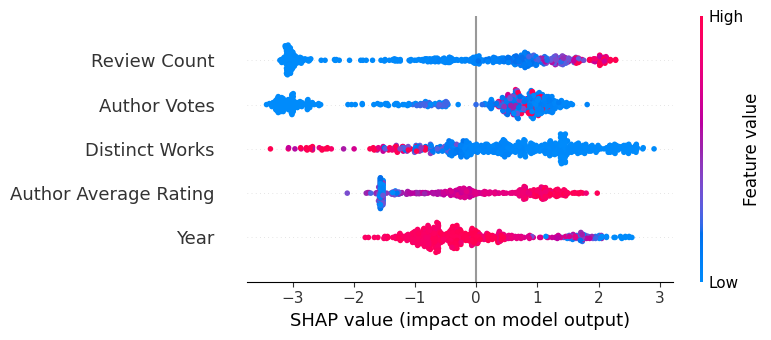

In [65]:
shap.summary_plot(shap_values, X_test)

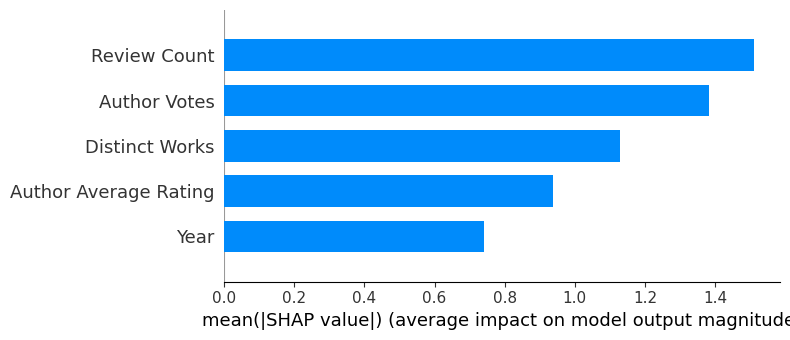

In [67]:
shap.summary_plot(shap_values, X_test, plot_type="bar")